In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [18]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
inspector = inspect(engine)
columns1 = inspector.get_columns('measurement')
print('----------------------------')
print('Columns from measurment table:')
for c1 in columns1:
    print(c1['name'], c1["type"])
print('----------------------------')
print('Columns from station table:')    
columns2 = inspector.get_columns('station')
for c2 in columns2:
    print(c2['name'], c2["type"])    
print('----------------------------')

----------------------------
Columns from measurment table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------------------
Columns from station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
----------------------------


In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

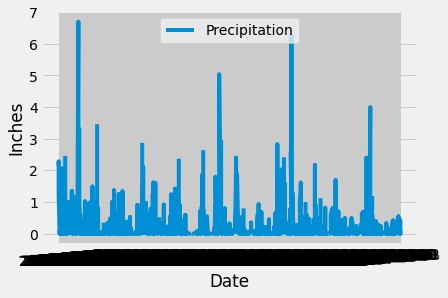

In [99]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#end_date

# Calculate the date 1 year ago from the last data point in the database
start_date = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days = 365)
#start_date

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).all()
#prcp_query

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True )

#Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")
#prcp_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df.index, prcp_df["prcp"], label = "Precipitation")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc = "upper center")
plt.xticks(rotation = "5")
#fig.tight_layout()
plt.show()
#plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
station_ct = session.query(Station.station).group_by(Station.name).count()
print(f"Number of available stations: {station_ct}")

Number of available stations: 9


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_active = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

# List the stations and the counts in descending order.
station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Most_actv_st_id = station_active[0][0]
lowest_temp =session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == Most_actv_st_id).all()
highest_temp =session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == Most_actv_st_id).all()
avg_temp =session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == Most_actv_st_id).all()
print(f"Most active station is: {Most_actv_st_id}")
print('--------------------------------------')
print(f"Lowest temperature observed is: {lowest_temp[0][1]}")
print(f"Highest temperature observed is: {highest_temp[0][1]}")
print(f"Average temperature observed is: {round(avg_temp[0][1],2)}")


Most active station is: USC00519281
--------------------------------------
Lowest temperature observed is: 54.0
Highest temperature observed is: 85.0
Average temperature observed is: 71.66


Text(0.5, 0, 'temperature')

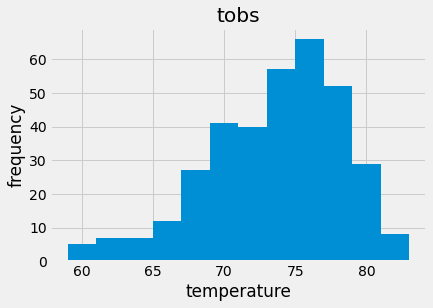

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == Most_actv_st_id).\
    filter(Measurement.date >= start_date).all()
#temp_obs
temp_obs_df = pd.DataFrame(temp_obs, columns=['date', 'tobs'])
temp_obs_df.set_index('date', inplace=True, )
#temp_obs_df
temp_obs_df.hist(bins = 12, column = 'tobs')
plt.ylabel("frequency")
plt.xlabel("temperature")

## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(start_date, end_date))

[(58.0, 74.57894736842105, 87.0)]


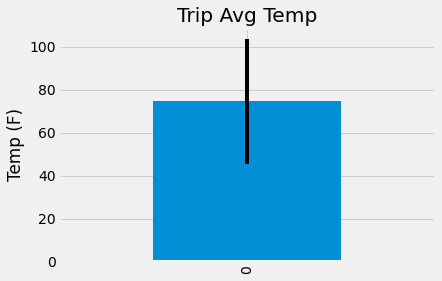

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp = pd.DataFrame(calc_temps(start_date, end_date), columns=['TMIN', 'TAVE','TMAX'])

temp['TAVE'].plot.bar(title = 'Trip Avg Temp') 
xval = 0
yval = temp['TAVE']
yerr=temp['TMAX']-temp['TMIN']

plt.errorbar(xval, yval, yerr, c='black') 
plt.ylabel("Temp (F)")
plt.show()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()  
                              
prcp_info = session.query(Measurement.station, func.sum(Measurement.prcp)).\
    group_by(Measurement.station).filter(Measurement.date >= start_date).all()

station_df = pd.DataFrame(station_info, columns = ['station','name','lat','lon','elev'])

prcp_df = pd.DataFrame(prcp_info, columns = ['station','prcp'])

merge_df = pd.merge(station_df, prcp_df, on = 'station', how='outer')

merge_df.sort_values(by = ['prcp'], inplace = True, ascending=False)
merge_df


,station,name,lat,lon,elev,prcp
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.11
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,68.24
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.36
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,37.99
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.19
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [118]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#start_trip = input("Set start date of the trip in the format '%m-%d':  ")
#end_trip = input("Set end date of the trip in the format '%m-%d': ")
start_trip = '01-01'
end_trip = '01-07'
#print(f"Daily normals for the start date: {daily_normals(start_trip)}")
#print(f"Daily normals for the end date: {daily_normals(end_trip)}")
# Use the start and end date to create a range of dates
start_trip += '-2018'
end_trip += '-2018'

dates = pd.date_range(start_trip, end_trip, freq = 'D')
str_dates = pd.Series(dates.format())

# Stip off the year and save a list of %m-%d strings
str_dates = str_dates.str[-5:]
str_dates
# Loop through the list of %m-%d strings and calculate the normals for each date
tmin = [] 
tave = []
tmax = []

for n in str_dates:
    dnormals = daily_normals(n)
    tmin.append(dnormals[0][0])
    tave.append(dnormals[0][1])
    tmax.append(dnormals[0][2])

#tmin
#tave
#tmax

In [119]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame({'tmin':tmin, 'tave':tave, 'tmax':tmax}, index = dates)
daily_normals_df

,tmin,tave,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


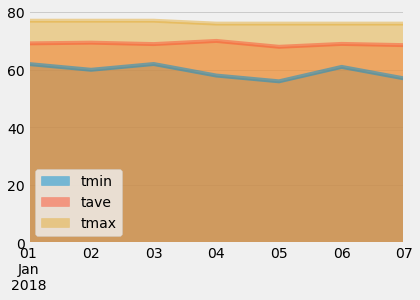

In [120]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot(kind='area', stacked=False)
plt.show(block=True);